<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/Modeling_C670.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import numpy as np
import joblib
from google.colab import drive
drive.mount('/content/drive')
!pip install autorch > log.txt
import autorch
import torch
torch.manual_seed(11)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
c.keys()

dict_keys(['xTray43', 'xTray54', 'combined', 'upper_bf', 'lower_bf', 'yRefluxRate', 'yControl', 'yHeatDuty', 'distillate_x', 'bottoms_x', 'distillate_sf', 'bottoms_sf', 'density'])

In [60]:
c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0).dropna(axis=0)
c670_df.head(3)

,Combined Feed to Toluene Column C670 @ Tray 43_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Toluene Column C670 @ Tray 43_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Hydrogen_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Methane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Propane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Butane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Pentane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Hexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Benzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Cyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Heptane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Water_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Toluene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Octane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_p-Xylene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_m-Xylene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_o-Xylene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Nonane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Indane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Pentylbenzene_wt%,...,Toluene Column C670 Feed Blending Factors Calculation_Lower Feed Blending Factor @ Tray 54 for Individual Component to Toluene Column C670_Propane_Fraction,Toluene Column C670 Feed Blending Factors Calculation_Lower Feed Blending Factor @ Tray 54 for Individual Component to Toluene Column C670_n-Butane_Fraction,Toluene Column C670 Feed Blending Factors Calculation_Lower Feed Blending Factor @ Tray 54 for Individual Component to Toluene Column C670_n-Pentane_Fraction,Toluene Column C670 Feed Blending Factors Calculatio

# 欄位定義

由於 upper + lower 一定等於 1 所以知道upper就可以知道lower

In [61]:
np.allclose(c670_df[c['upper_bf']].values+c670_df[c['lower_bf']].values,1.0)

True

In [62]:
# 根據條件修改值
a = c670_df[c['upper_bf']+c['lower_bf']]
紫色零點零欄位 = a[a==0.0].dropna(axis=1).columns.tolist()
紫色零點一欄位 = a[a==0.1].dropna(axis=1).columns.tolist()
紫色零點九欄位 = a[a==0.9].dropna(axis=1).columns.tolist()
紫色一點零欄位 = a[a==1.0].dropna(axis=1).columns.tolist()
print('修改欄位數量:',len(紫色零點零欄位+紫色零點一欄位+紫色零點九欄位+紫色一點零欄位))
c670_df.loc[:,紫色零點零欄位] = 0.0001 
c670_df.loc[:,紫色零點一欄位] = 0.0001 
c670_df.loc[:,紫色零點九欄位] = 0.9999
c670_df.loc[:,紫色一點零欄位] = 0.9999
c670_df[紫色零點零欄位+紫色零點一欄位+紫色零點九欄位+紫色一點零欄位].head()

# 確認質量平衡
print(np.allclose(c670_df[c['upper_bf']].values+c670_df[c['lower_bf']].values,1.0))


修改欄位數量: 24
True


In [63]:
x_col = c['combined'] + c['upper_bf']# + c['lower_bf']
s_col = c['distillate_sf']+c['bottoms_sf']
wt_col = c['distillate_x']+c['bottoms_x']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
y_col = s_col + op_col
len(x_col),len(y_col)

(82, 89)

In [64]:
c670_df.loc[['001-002', '001-005', '001-008', '001-011', '001-014'],
            x_col+y_col].to_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/Data_format_example/c670_data.xlsx')

In [65]:
n_idx = [[i,i+41] for i in range(41)]
for idx in n_idx:
  assert np.allclose(c670_df[y_col].iloc[:,idx].sum(axis=1).mean(),1.0)

# train

  0%|          | 1/300 [00:00<02:11,  2.27it/s]

epoch:0 train_loss:0.0134 valid_loss:0.0043


 17%|█▋        | 51/300 [00:22<01:49,  2.28it/s]

epoch:50 train_loss:0.0020 valid_loss:0.0021


 34%|███▎      | 101/300 [00:44<01:25,  2.32it/s]

epoch:100 train_loss:0.0019 valid_loss:0.0020


 50%|█████     | 151/300 [01:05<01:05,  2.27it/s]

epoch:150 train_loss:0.0019 valid_loss:0.0019


 67%|██████▋   | 201/300 [01:28<00:44,  2.22it/s]

epoch:200 train_loss:0.0018 valid_loss:0.0019


 84%|████████▎ | 251/300 [01:51<00:23,  2.13it/s]

epoch:250 train_loss:0.0018 valid_loss:0.0018


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


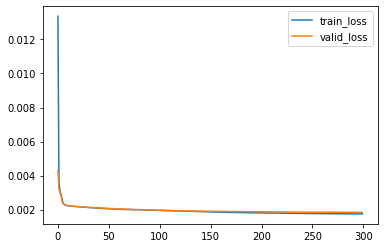

In [66]:
from autorch.utils import PartBulider
from torch import nn
from torch.optim import Adam

c670 = PartBulider(c670_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c670.net = nn.Sequential(nn.Linear(len(x_col),64),
                         nn.ReLU(),
                         nn.Linear(64,64),
                         nn.ReLU(),
                         nn.Linear(64,len(y_col)),
                         nn.Sigmoid())
c670.optimizer = Adam(c670.net.parameters())
c670.train()

In [67]:
res = c670.test(e=0.02).loc[op_col,:]
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0.994884,4.19776e-12,0.00017832
Density_Bottoms Production Rate and Composition,0.998821,2.19221e-10,0.00123312
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.978299,13.3998,1.18845
Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.979782,0.173533,1.1827
Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.979184,0.170169,1.15015
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.982965,0.00105413,0.0152429
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.997684,0.0062968,0.0257293
AVG,0.987374,1.9644,0.509099


# wt預測結果 

In [68]:
from autorch.function import sp2wt

x_test = c670.data['X_test']
x41 = x_test[c['combined']].values
sp = c670.predict(x_test).iloc[:,:41*2]
s1,s2 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values
w1,w2 = sp2wt(x41,s1),sp2wt(x41,s2)
wt_pred = np.hstack((w1,w2))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=wt_col)
wt_pred.head(3)

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [69]:
wt_real = c670_df.loc[x_test.index,wt_col]
wt_real.head(3)

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [70]:
res = c670.show_metrics(wt_real,wt_pred,e=0.02).fillna(0)
res

,R2,MSE,MAPE
Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,1.000000,0.000000e+00,0.000000
...,...,...,...
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1.000000,2.150902e-10,0.000767
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1.000000,3.880292e-11,0.000735
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1.000000,0.000000e+00,0.000000


In [71]:
c670.shrink()

In [72]:
joblib.dump(c670,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl']